### Estudo de AE e VAE

[AE] Epoch 1, Loss: 0.0622
[AE] Epoch 2, Loss: 0.0514
[AE] Epoch 3, Loss: 0.0491
[AE] Epoch 4, Loss: 0.0478
[AE] Epoch 5, Loss: 0.0470
[AE] Epoch 6, Loss: 0.0465
[AE] Epoch 7, Loss: 0.0460
[AE] Epoch 8, Loss: 0.0456
[AE] Epoch 9, Loss: 0.0452
[AE] Epoch 10, Loss: 0.0448
[VAE] Epoch 1, Loss: 207.7628
[VAE] Epoch 2, Loss: 176.6282
[VAE] Epoch 3, Loss: 169.3248
[VAE] Epoch 4, Loss: 166.4270
[VAE] Epoch 5, Loss: 164.9447
[VAE] Epoch 6, Loss: 163.8595
[VAE] Epoch 7, Loss: 162.9274
[VAE] Epoch 8, Loss: 162.0463
[VAE] Epoch 9, Loss: 161.2401
[VAE] Epoch 10, Loss: 160.5598


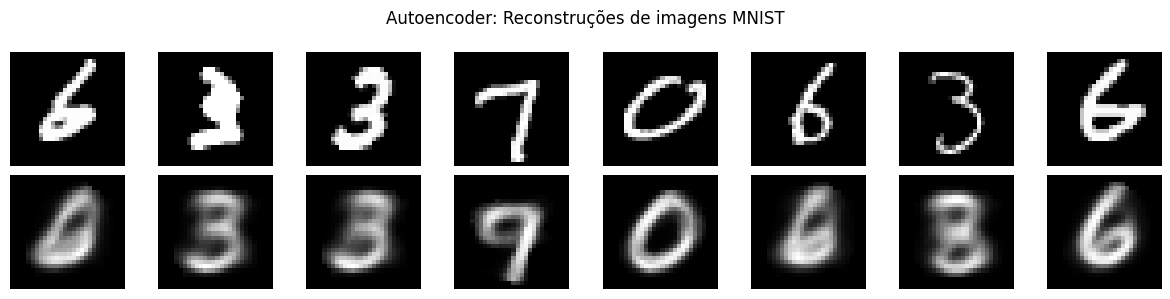

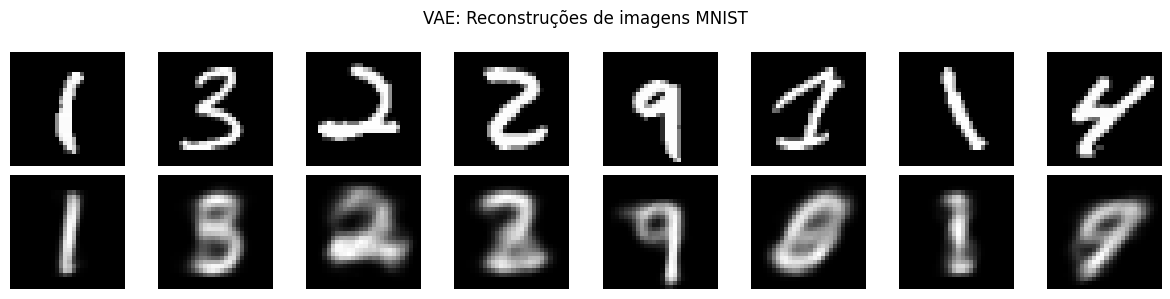

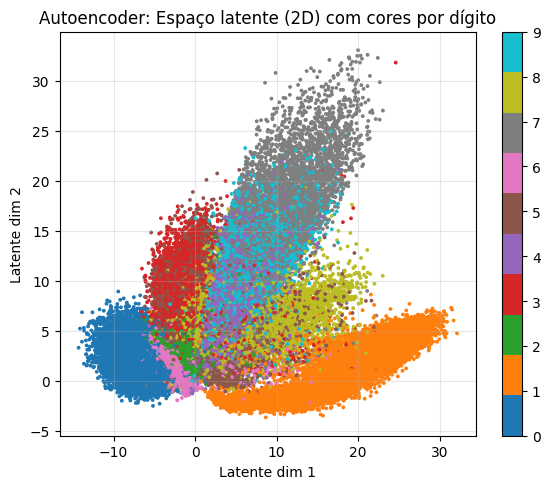

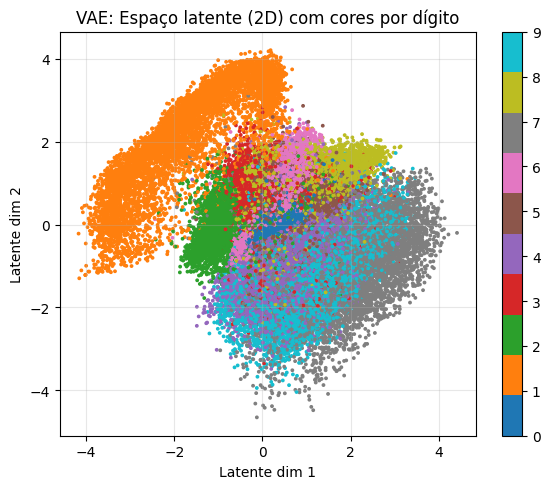

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2  # para fácil visualização
batch_size = 128
epochs = 10

# Dados MNIST
transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)

# AE
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# VAE
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 128), nn.ReLU())
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# Treinamento
def train_ae(model, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[AE] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

def train_vae(model, optimizer):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            x_recon, mu, logvar = model(x)
            recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            loss = recon_loss + kl
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[VAE] Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# Instanciar e treinar
ae = Autoencoder().to(device)
vae = VAE().to(device)
train_ae(ae, optim.Adam(ae.parameters()), nn.MSELoss())
train_vae(vae, optim.Adam(vae.parameters()))

# Visualização reconstrutiva
def show_reconstructions(model, vae=False):
    model.eval()
    x, _ = next(iter(train_loader))
    x = x.to(device)[:8]
    with torch.no_grad():
        if vae:
            x_recon, _, _ = model(x)
        else:
            x_recon = model(x)
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(x[i, 0].cpu(), cmap='gray')
        axes[1, i].imshow(x_recon[i, 0].cpu(), cmap='gray')
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    model_name = "VAE" if vae else "Autoencoder"
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Recon")
    plt.suptitle(f"{model_name}: Reconstruções de imagens MNIST")
    plt.tight_layout()
    plt.show()

show_reconstructions(ae)
show_reconstructions(vae, vae=True)

# Visualização do espaço latente
def plot_latent_space(model, vae=False):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in train_loader:
            x = x.to(device)
            if vae:
                _, mu, _ = model(x)
                z = mu
            else:
                z = model.encoder(x)
            zs.append(z.cpu())
            labels.append(y)
    zs = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap='tab10', s=3)
    plt.colorbar(scatter)
    model_name = "VAE" if vae else "Autoencoder"
    plt.title(f"{model_name}: Espaço latente (2D) com cores por dígito")
    plt.xlabel("Latente dim 1")
    plt.ylabel("Latente dim 2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plot_latent_space(ae)
plot_latent_space(vae, vae=True)

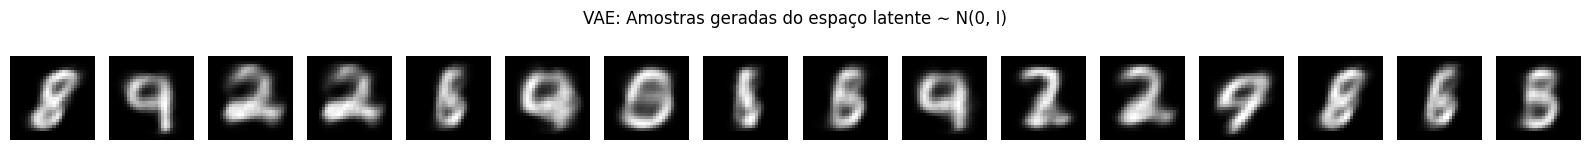

In [41]:
def generate_samples_from_latent(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decoder(z).cpu()

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1.5))
    for i in range(num_samples):
        axes[i].imshow(samples[i, 0], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"VAE: Amostras geradas do espaço latente ∼ N(0, I)")
    plt.tight_layout()
    plt.show()
    
generate_samples_from_latent(vae, num_samples=16)


In [52]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_latent_space(model, data_loader, device, title='Latent space', use_tsne=True):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            if hasattr(model, 'encoder'):
                out = model.encoder(x)
                # Se for VAE (tupla), pega só o mu
                if isinstance(out, tuple) or isinstance(out, list):
                    mu = out[0]
                    z = mu
                else:
                    z = out
            else:
                # Caso o modelo não tenha encoder definido (incomum)
                z = model(x)

            latents.append(z.cpu())
            labels.append(y)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    # Redução de dimensionalidade
    if use_tsne:
        reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
    else:
        reducer = PCA(n_components=2)

    latents_2d = reducer.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f"{title} ({'T-SNE' if use_tsne else 'PCA'})")
    plt.xlabel("Latent dim 1")
    plt.ylabel("Latent dim 2")
    plt.tight_layout()
    plt.show()


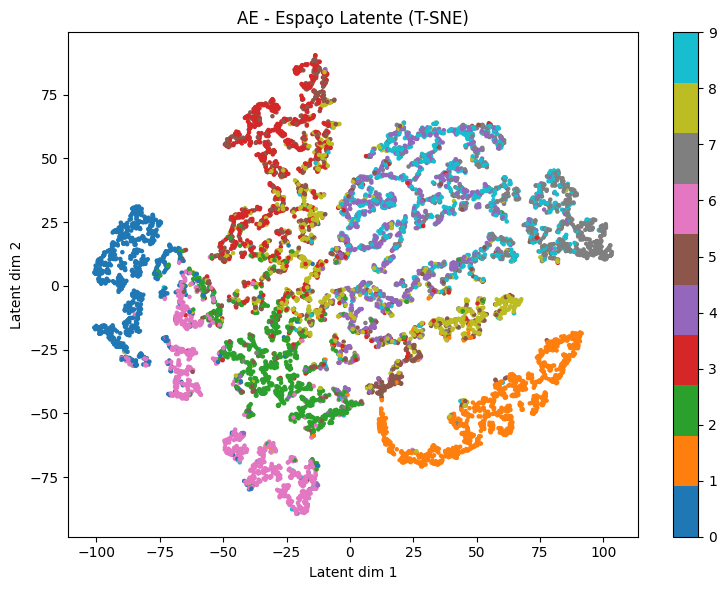

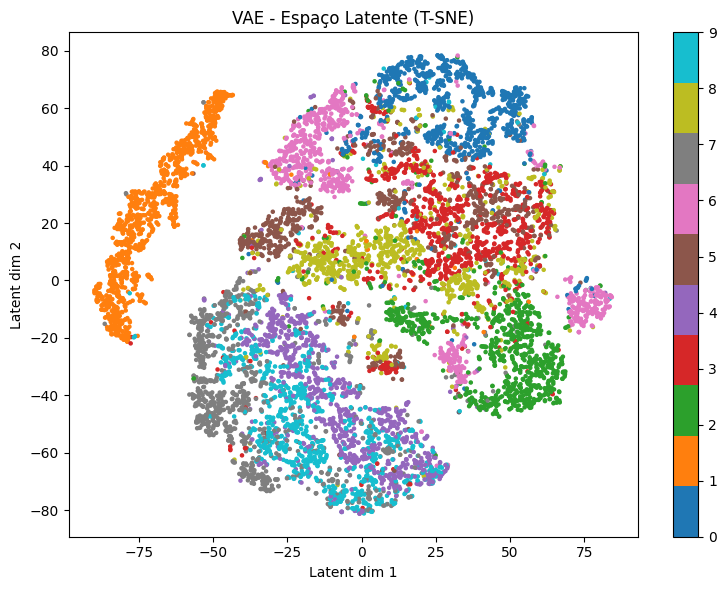

In [50]:
plot_latent_space(ae, test_loader, device, title="AE - Espaço Latente")
plot_latent_space(vae, test_loader, device, title="VAE - Espaço Latente")


### Estudo denovas estruturas moleculares

In [71]:
# !pip install kagglehub

In [67]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("basu369victor/zinc250k")

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████| 8.60M/8.60M [00:01<00:00, 6.46MB/s]

Extracting files...


Path to dataset files: /Users/walterjr/.cache/kagglehub/datasets/basu369victor/zinc250k/versions/1


Moléculas válidas: 249455/249455


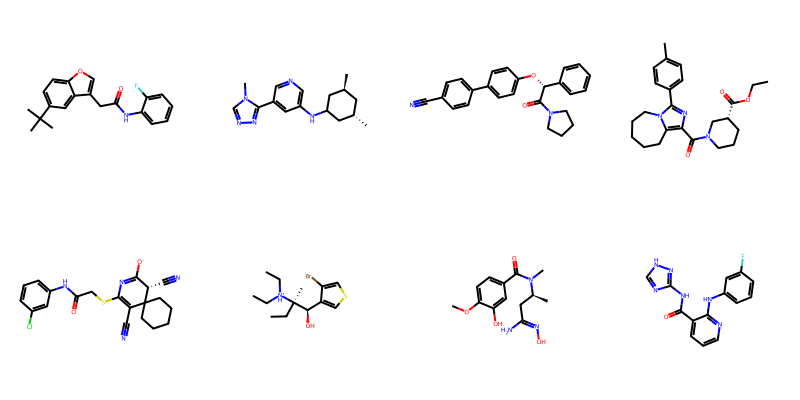

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

# Carregar o arquivo TSV (tab-separado) e usar a coluna 'smiles'
data = pd.read_csv(
    '/Users/walterjr/IA/250k_rndm_zinc_drugs_clean_3.csv',
    sep=',',  # Importante: especificar que é separado por TAB
    usecols=['smiles']  # Seleciona apenas a coluna de SMILES
)

# Filtrar SMILES válidos
valid_mols = []
for s in data['smiles']:
    mol = Chem.MolFromSmiles(s)
    if mol is not None:
        valid_mols.append(mol)

print(f"Moléculas válidas: {len(valid_mols)}/{len(data)}")

# Visualizar exemplos
Draw.MolsToGridImage(valid_mols[:8], molsPerRow=4)

In [6]:
from rdkit.Chem import Descriptors
for mol in valid_mols[:5]:
    print(f"SMILES: {Chem.MolToSmiles(mol)}")
    print(f"Peso Molecular: {Descriptors.MolWt(mol):.2f}")
    print(f"LogP: {Descriptors.MolLogP(mol):.2f}\n")

SMILES: CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
Peso Molecular: 325.38
LogP: 5.05

SMILES: C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
Peso Molecular: 285.40
LogP: 3.11

SMILES: N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1
Peso Molecular: 382.46
LogP: 4.97

SMILES: CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCCC3)C1
Peso Molecular: 409.53
LogP: 4.00

SMILES: N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#N)C12CCCCC2
Peso Molecular: 413.91
LogP: 3.61



In [9]:
import numpy as np
from rdkit import Chem
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Tokenização com TensorFlow/Keras moderno
tokenizer = Tokenizer(char_level=True, lower=False)
smiles_list = [Chem.MolToSmiles(mol) for mol in valid_mols]
tokenizer.fit_on_texts(smiles_list)

# 2. Convertendo SMILES para sequências numéricas
sequences = tokenizer.texts_to_sequences(smiles_list)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# 3. One-hot encoding manual (simples)
vocab_size = len(tokenizer.word_index) + 1
one_hot = np.zeros((len(padded_sequences), max_length, vocab_size))
for i, seq in enumerate(padded_sequences):
    one_hot[i, np.arange(max_length), seq] = 1

print(f"Shape do one-hot: {one_hot.shape}")  # (n_moléculas, max_length, vocab_size)

Shape do one-hot: (249455, 109, 35)


In [183]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

vocab_size = 30
max_length = 60
latent_dim = 32
N = 5000

one_hot = np.random.rand(N, max_length, vocab_size).astype(np.float32)

# Encoder
encoder_inputs = tf.keras.Input(shape=(max_length, vocab_size))
x = layers.LSTM(128)(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.RepeatVector(max_length)(latent_inputs)
x = layers.LSTM(128, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

@register_keras_serializable()
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(data, reconstruction), axis=1
                )
            )
            total_loss = reconstruction_loss + sum(self.losses)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    # ESSENCIAL: sobrescreve get_config para salvar encoder e decoder
    def get_config(self):
        config = super().get_config()
        # Usamos a função to_json para salvar a arquitetura
        config.update({
            "encoder_config": self.encoder.to_json(),
            "decoder_config": self.decoder.to_json(),
        })
        return config

    # ESSENCIAL: sobrescreve from_config para reconstruir encoder e decoder
    @classmethod
    def from_config(cls, config):
        import tensorflow.keras.models as keras_models
        encoder = keras_models.model_from_json(config.pop("encoder_config"))
        decoder = keras_models.model_from_json(config.pop("decoder_config"))
        return cls(encoder=encoder, decoder=decoder, **config)

# Criar e treinar
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(one_hot, epochs=100, batch_size=128, validation_split=0.1)

# Salvar
vae.save("vae_mol_light.keras")

# Para carregar:
from tensorflow.keras.models import load_model
vae_loaded = load_model("vae_mol_light.keras", custom_objects={"VAE": VAE, "Sampling": Sampling})

print("Modelo carregado com sucesso!")


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 3081.3240 - val_loss: 0.0000e+00
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 3063.4043 - val_loss: 0.0000e+00
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 3062.2803 - val_loss: 0.0000e+00
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 3061.6140 - val_loss: 0.0000e+00
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 3062.3103 - val_loss: 0.0000e+00
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 3062.4873 - val_loss: 0.0000e+00
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 3061.0107 - val_loss: 0.0000e+00
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 3061.7598 - val_loss: 0.0000e+00
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 3062.5447 - val_loss: 0.0000e+00
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 3060.8564 - val_loss: 0.0000e+00
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - los

In [185]:
import numpy as np

# Amostra pontos aleatórios no espaço latente
z_random = np.random.normal(size=(10, latent_dim))

# Gera novas sequências com o decoder
generated = vae_loaded.decoder.predict(z_random)
print(generated.shape)  # (10, max_length, vocab_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
(10, 60, 30)


In [187]:
sample_input = one_hot[:1]  # uma amostra do conjunto de dados
z_mean, z_log_var, z = vae_loaded.encoder.predict(sample_input)
reconstruction = vae_loaded.decoder.predict(z)
print(reconstruction.shape)  # deve ser (1, max_length, vocab_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
(1, 60, 30)


In [199]:
import numpy as np

# número de amostras que quer gerar
n_samples = 100

# amostrando z do espaço latente normal padrão
z_samples = np.random.normal(size=(n_samples, latent_dim))

# gerar as sequências one-hot do decoder
decoded = vae_loaded.decoder.predict(z_samples)  # shape (100, 60, 30)

# para cada sequência, converter one-hot para índice máximo por timestep
decoded_indices = np.argmax(decoded, axis=-1)  # shape (100, 60)

# Exemplo de print das primeiras 5 sequências de índices (que correspondem a tokens)
for i in range(5):
    print(f"Seq {i} indices:", decoded_indices[i])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Seq 0 indices: [13 13 13 13 13 13 14 14 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18]
Seq 1 indices: [28 21 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23]
Seq 2 indices: [21  4  4  4  4  4 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23]
Seq 3 indices: [26  9 14 14 14 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17]
Seq 4 indices: [19 20 20 20 20 20 20 20 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 24 2

In [191]:
import numpy as np

# 1. Gerar z aleatório no espaço latente
n_samples = 100
z_samples = np.random.normal(size=(n_samples, latent_dim))

# 2. Decodificar z para sequências one-hot com o decoder do seu VAE
decoded = vae_loaded.decoder.predict(z_samples)  # (100, max_length, vocab_size)

# 3. Converter one-hot para índices (token IDs)
decoded_indices = np.argmax(decoded, axis=-1)  # (100, max_length)

# 4. Converter índices para caracteres usando o tokenizer (index_word é dict índice -> caractere)
index_word = {v: k for k, v in tokenizer.word_index.items()}

# Note: índice 0 é padding, não tem caractere no tokenizer (não está no index_word)
# Então vamos ignorar zeros na hora de montar a string.

# 5. Montar SMILES a partir dos índices
smiles_generated = []
for seq in decoded_indices:
    chars = [index_word.get(idx, '') for idx in seq if idx != 0]  # ignorar padding (0)
    smiles = ''.join(chars)
    smiles_generated.append(smiles)

# Mostrar alguns exemplos
for i in range(10):
    print(f"Molécula {i+1}: {smiles_generated[i]}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Molécula 1: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
Molécula 2: -lll44444///////////////////////////////////////////////////
Molécula 3: \)))))))4444444444444444444444444444444444444444444444444444
Molécula 4: -OOO44SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
Molécula 5: B)))))))))))))))))))))))))))))))))))))))))))))))))))))))))))
Molécula 6: CCCC]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]
Molécula 7: \\nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
Molécula 8: s))))///ssssssssssssssssssssssssssssssssssssssssssssssssssss
Molécula 9: B////444////////////////////////////////////////////////////
Molécula 10: ]]HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


In [193]:
from rdkit import Chem

valid_smiles = []
for s in smiles_generated:
    mol = Chem.MolFromSmiles(s)
    if mol is not None:
        valid_smiles.append(s)

print(f"Geradas: {len(smiles_generated)}, Válidas: {len(valid_smiles)}")
print("Algumas SMILES válidas:")
for smi in valid_smiles[:10]:
    print(smi)


Geradas: 100, Válidas: 2
Algumas SMILES válidas:
BSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS
CCOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO


[21:32:17] SMILES Parse Error: syntax error while parsing: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
[21:32:17] SMILES Parse Error: check for mistakes around position 1:
[21:32:17] HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
[21:32:17] ^
[21:32:17] SMILES Parse Error: Failed parsing SMILES 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH' for input: 'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH'
[21:32:17] SMILES Parse Error: syntax error while parsing: -lll44444///////////////////////////////////////////////////
[21:32:17] SMILES Parse Error: check for mistakes around position 1:
[21:32:17] -lll44444////////////////////////////////
[21:32:17] ^
[21:32:17] SMILES Parse Error: Failed parsing SMILES '-lll44444///////////////////////////////////////////////////' for input: '-lll44444///////////////////////////////////////////////////'
[21:32:17] SMILES Parse Error: syntax error while parsing: \)))))))4444444444444444444444444444444444444444444

In [195]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [197]:
decoded_indices_temp = []
temperature = 0.8  # ajuste entre 0.5 e 1.5 para explorar diferentes diversidades

for seq_probs in decoded:
    seq_indices = [sample_with_temperature(token_probs, temperature) for token_probs in seq_probs]
    decoded_indices_temp.append(seq_indices)

# Depois converta decoded_indices_temp para SMILES como antes
